##Interpretability

In [ ]:
%pip install xplique
%pip install deeplake
%pip install deeplake[audio]
%pip install 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.9/475.9 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

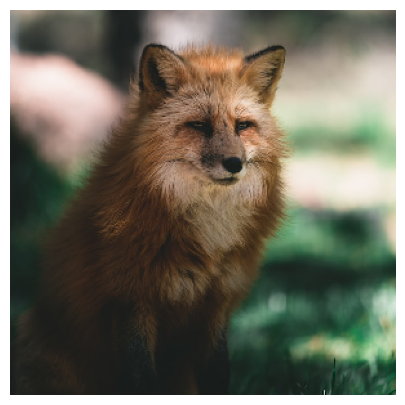

In [ ]:
from itertools import product
from math import ceil
from time import time

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn import linear_model
from skimage.segmentation import quickshift, felzenszwalb, watershed, slic
from skimage.color import rgb2gray
from skimage.filters import sobel

import xplique
from xplique.attributions import Lime, KernelShap
from xplique.plots import plot_attributions

# load, prepare and show the sample
!wget -q 'https://unsplash.com/photos/XOxsVJmCyxk/download?force=true&w=640' -O 'fox.jpg'

x = np.expand_dims(tf.keras.preprocessing.image.load_img("fox.jpg", target_size=(299, 299)), 0)
x = np.array(x, dtype=np.float32) / 255.0

y = np.expand_dims(tf.keras.utils.to_categorical(277, 1000), 0)

plt.rcParams["figure.figsize"] = [12.5, 5]
plt.imshow(x[0])
plt.axis('off')
plt.show()

Lime


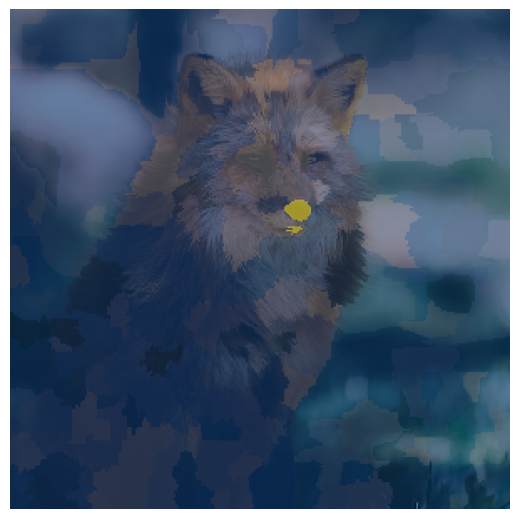

KernelShap


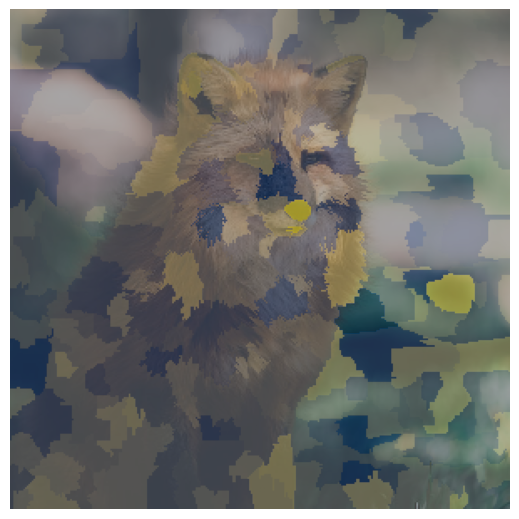

In [ ]:
# Xplique example
model = tf.keras.applications.InceptionV3()

common_parameters = {
    "model": model,
    "batch_size": 16,
    "map_to_interpret_space": None,  # will use the default function
    "nb_samples": 1000,
    "ref_value": None,  # default value  will use (0.5, 0.5, 0.5) for images
}

lime_specific_parameters = {
    "interpretable_model": linear_model.Ridge(alpha=2),
    "similarity_kernel": None,  # will use the default function
    "pertub_func": None,  # will use the default function
    "distance_mode": "euclidean",  # default value
    "kernel_width": 45.0,  # default value adapted for 224x224 images
    "prob": 0.5,  # default value
}

# instanciate one explainer for each method
explainers = {
    "Lime": Lime(**common_parameters, **lime_specific_parameters),
    "KernelShap": KernelShap(**common_parameters),
}

# iterate on all methods
for method_name, explainer in explainers.items():
    # compute explanation by calling the explainer
    explanation = explainer.explain(x, y)

    # visualize explanation with plot_explanation() function
    print(method_name)
    plot_attributions(explanation, x, img_size=5, cmap='cividis', cols=1, alpha=0.6)
    plt.show()

In [ ]:
# load our data
from google.colab import drive
import librosa
import deeplake
import tensorflow as tf
import sys 


drive.mount('/content/drive', force_remount=True)

import pickle
with open('/content/drive/MyDrive/DL Project/data/specs.pkl', 'rb') as f:
    data = pickle.load(f)
f.close()

with open('/content/drive/MyDrive/DL Project/data/genres.pkl', 'rb') as f:
    genres = pickle.load(f)
f.close()

genres = genres.numpy()


Mounted at /content/drive


In [ ]:
# Load the pre-trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/DL Project/data/temp/")

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

train_idx, test_idx = train_test_split(range(1000), test_size=0.2, shuffle=True, random_state=1)

train_data, train_labels = data[train_idx], genres[train_idx]
test_data, test_labels = data[test_idx], genres[test_idx]

# add "color" channel
train_data = tf.expand_dims(train_data, axis = -1)
test_data = tf.expand_dims(test_data, axis = -1)



In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
# use a Sequential to normalize the data
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(train_data)

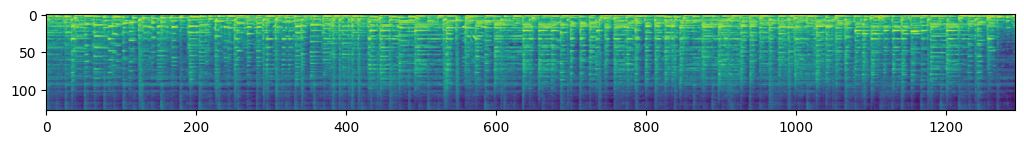

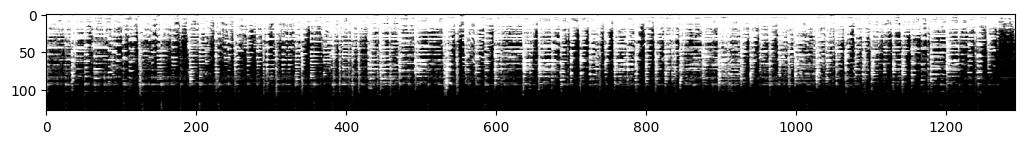

In [ ]:
import matplotlib.pyplot as plt


x = test_data[0]
plt.imshow(x)
plt.show()
x = data_augmentation(x)


x = tf.image.grayscale_to_rgb(
    x, name=None
)

plt.imshow(x[0])
plt.show()


In [ ]:
# Now use our model
import xplique
from xplique.attributions import SobolAttributionMethod, Rise, Lime, KernelShap, SmoothGrad, GradCAM
from xplique.plots import plot_attributions
import numpy as np 
from sklearn import linear_model


x = test_data[0]
x = data_augmentation(x)


x = tf.image.grayscale_to_rgb(
    x, name=None
)
model.layers[-1].activation = tf.keras.activations.linear

# Effectively one hot encodes
y = np.expand_dims(tf.keras.utils.to_categorical(test_labels[0], 10), 0)

y = tf.squeeze(y, axis = 0)

explainers = [
             #Saliency(model),
             #GradientInput(model),
             #GuidedBackprop(model),
             #IntegratedGradients(model, steps=50, batch_size=batch_size),
             SmoothGrad(model, nb_samples=200, batch_size=32),
             #SquareGrad(model, nb_samples=50, batch_size=batch_size),
             #VarGrad(model, nb_samples=50, batch_size=batch_size),
             GradCAM(model, output_layer = -1, batch_size =16, conv_layer = "multi_head_attention_4"),
             #GradCAMPP(model),
             #Occlusion(model, patch_size=10, patch_stride=10, batch_size=batch_size),
             #SobolAttributionMethod(model, batch_size=32),
             Rise(model, nb_samples=4000, batch_size=32),
              Rise(model, nb_samples=4000, batch_size=32, grid_size = 24),
             Lime(model, nb_samples = 2000, batch_size = 32, interpretable_model = linear_model.Ridge(alpha=2)),
             KernelShap(model, nb_samples = 2000, batch_size = 32)
]


for explainer in explainers:
    print("M")
    explanation = explainer.explain(x, y)

    # visualize explanation with plot_explanation() function
    plot_attributions(explanation,x, img_size=25, cmap='cividis', cols=1, alpha=0.6)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

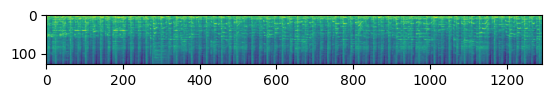

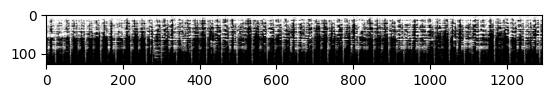

M


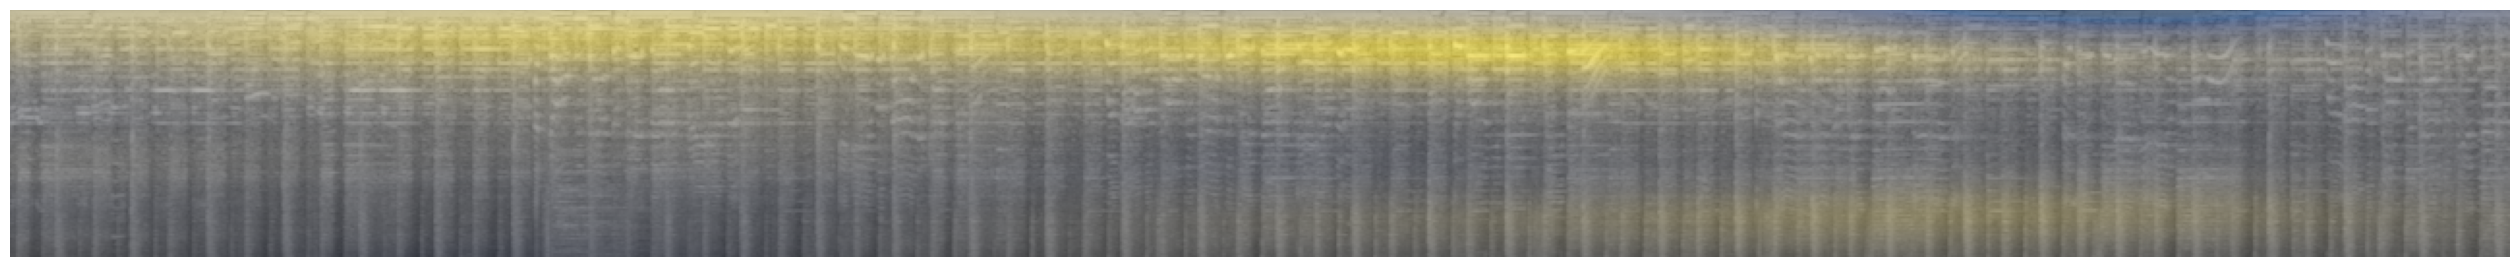

In [ ]:
# Using a differenct input
import xplique
from xplique.attributions import SobolAttributionMethod, Rise, Lime, KernelShap, SmoothGrad, GradCAM
from xplique.plots import plot_attributions
import numpy as np 
from sklearn import linear_model

x = test_data[13]
plt.imshow(x)
plt.show()
x = data_augmentation(x)


x = tf.image.grayscale_to_rgb(
    x, name=None
)


# Effectively one hot encodes
y = np.expand_dims(tf.keras.utils.to_categorical(test_labels[13], 10), 0)

y = tf.squeeze(y, axis = 0)

explainers = [
             #Saliency(model),
             #GradientInput(model),
             #GuidedBackprop(model),
             #IntegratedGradients(model, steps=50, batch_size=batch_size),
             #SmoothGrad(model, nb_samples=200, batch_size=32),
             #SquareGrad(model, nb_samples=50, batch_size=batch_size),
             #VarGrad(model, nb_samples=50, batch_size=batch_size),
             #GradCAM(model, output_layer = -1, batch_size =16, conv_layer = "multi_head_attention_105"),
             #GradCAMPP(model),
             #Occlusion(model, patch_size=10, patch_stride=10, batch_size=batch_size),
             #SobolAttributionMethod(model, batch_size=32),
             Rise(model, nb_samples=4000, batch_size=32),
             #Rise(model, nb_samples=4000, batch_size=32, grid_size = 24),
             #Lime(model, nb_samples = 2000, batch_size = 32, interpretable_model = linear_model.Ridge(alpha=2)),
             #KernelShap(model, nb_samples = 2000, batch_size = 32)
]

for explainer in explainers:
    print("M")
    explanation = explainer.explain(x, y)

    # visualize explanation with plot_explanation() function
    plot_attributions(explanation,x, img_size=25, cmap='cividis', cols=1, alpha=0.6)
    plt.show()

## Visualize attention matrix

In [ ]:
model.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 128, 1293,   0           []                               
                                3)]                                                               
                                                                                                  
 patches_33 (Patches)           (None, None, 15360)  0           ['input_34[0][0]']               
                                                                                                  
 patch_encoder_33 (PatchEncoder  (None, 32, 64)      985152      ['patches_33[0][0]']             
 )                                                                                                
                                                                                           

In [ ]:
# Extract the attention weights
attention_layer = model.get_layer("multi_head_attention_4")
attention_model = tf.keras.models.Model(inputs=model.inputs, outputs=attention_layer.output)



(128, 1293, 1)
(128, 1293, 1)
1/1 [==============================] - 2s 2s/step
32


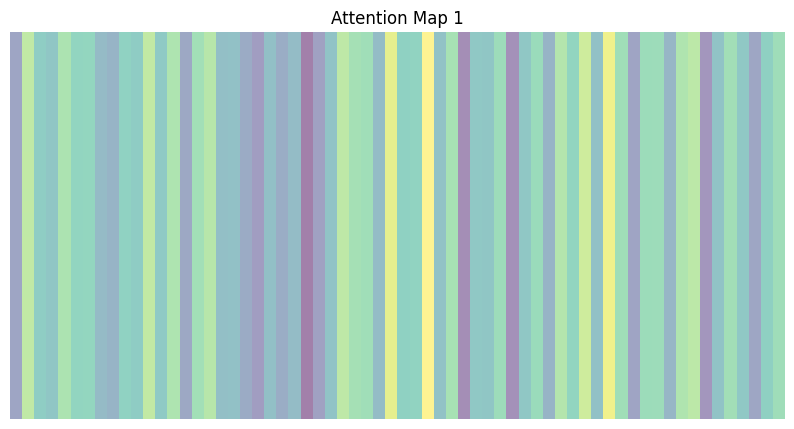

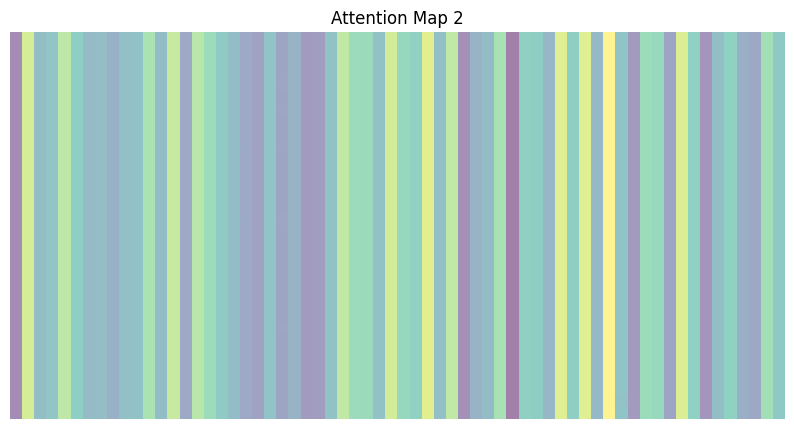

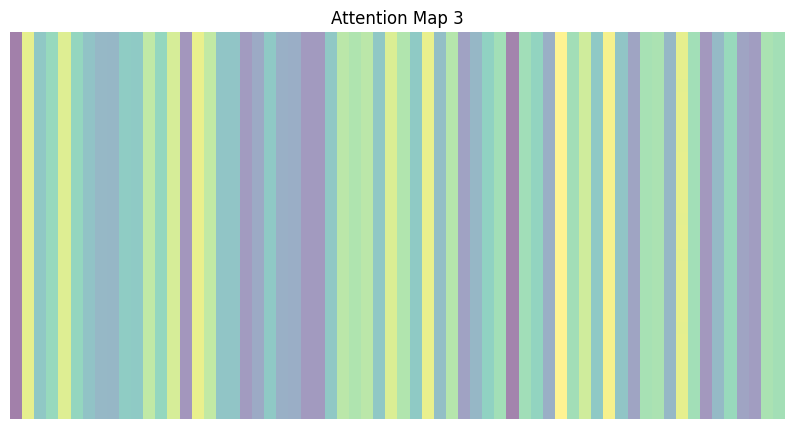

In [ ]:
from matplotlib import pyplot as plt

# Create a new model that outputs the attention weights
attention_extractor = tf.keras.Model(inputs=model.input,
                                     outputs=[layer.output for layer in model.layers if 'multi_head_attention' in layer.name])

# Compile the model and load the weights from the pre-trained model
attention_extractor.set_weights(model.get_weights()[0:45])

# Load the new input data and preprocess it as required
x = test_data[18]
print(x.shape)
#x = data_augmentation(x)
print(x.shape)

x = tf.expand_dims(x, axis = 0)
x = tf.image.grayscale_to_rgb(
    x, name=None
)

new_data = x

# Predict the output using the new input data and obtain the attention weights
attention_weights = attention_extractor.predict(new_data)


print(len(attention_weights[0][0]))

# Visualize the attention maps
for i, attention_weight in enumerate(attention_weights):
    plt.figure(figsize=(10, 10))
    #plt.imshow(new_data[i])
    plt.imshow(attention_weight[0], cmap='viridis', alpha=0.5)
    plt.axis('off')
    plt.title(f'Attention Map {i+1}')
    plt.show()

1/1 [==============================] - 0s 37ms/step


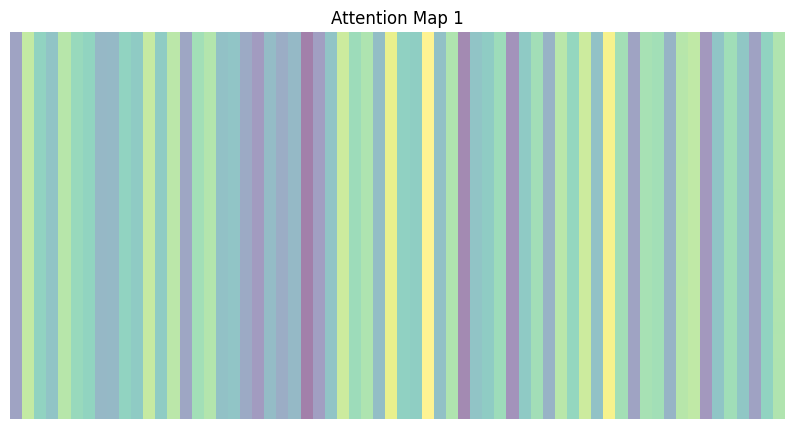

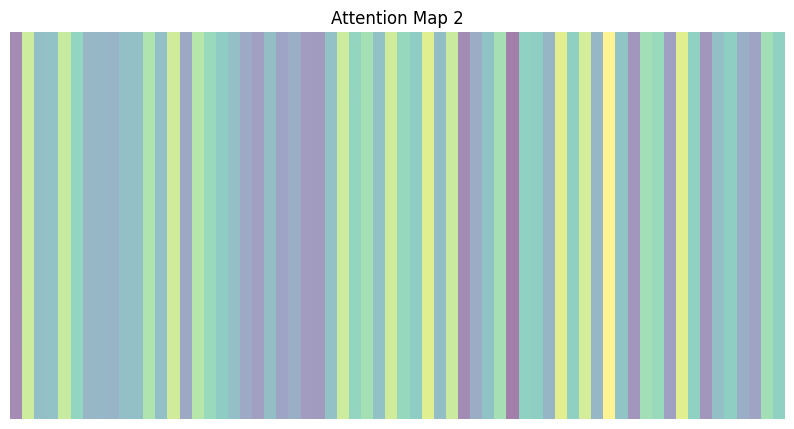

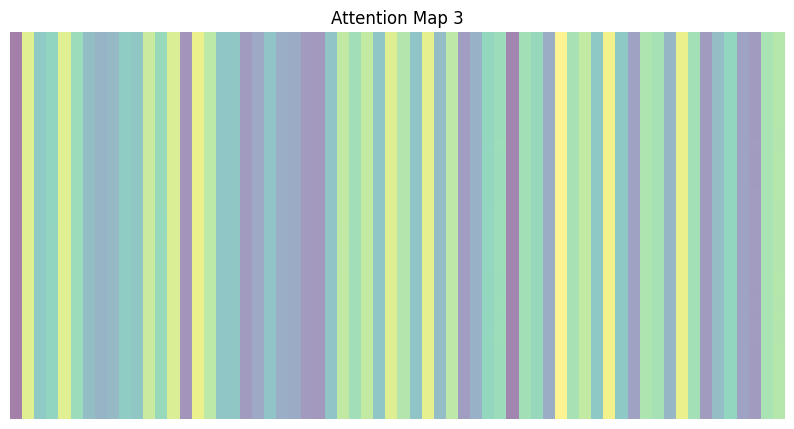

In [ ]:
# Using different input
from matplotlib import pyplot as plt

x = test_data[6]

x = tf.expand_dims(x, axis = 0)


x = tf.image.grayscale_to_rgb(
    x, name=None
)


new_data = x

# Predict the output using the new input data and obtain the attention weights
attention_weights = attention_extractor.predict(new_data)

# Visualize the attention maps
for i, attention_weight in enumerate(attention_weights):
    plt.figure(figsize=(10, 10))
    #plt.imshow(new_data[i])
    plt.imshow(attention_weight[0], cmap='viridis', alpha=0.5)
    plt.axis('off')
    plt.title(f'Attention Map {i+1}')
    plt.show()

(128, 1293, 1)
(128, 1293, 1)
1/1 [==============================] - 1s 941ms/step


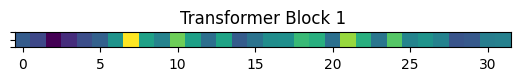

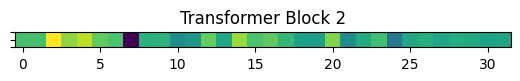

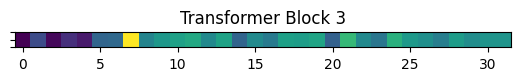

In [ ]:
# Create a new model that outputs the attention weights
attention_extractor = tf.keras.Model(inputs=model.input,
                                     outputs=[layer.output for layer in model.layers if 'multi_head_attention' in layer.name])

# Compile the model and load the weights from the pre-trained model
attention_extractor.set_weights(model.get_weights()[0:44])

# using indicies 0, 13

# Load the new input data and preprocess it as required
x = test_data[13]
print(x.shape)
#x = data_augmentation(x)
print(x.shape)

x = tf.expand_dims(x, axis = 0)
x = tf.image.grayscale_to_rgb(   x, name=None)

new_data = x

# Predict the output using the new input data and obtain the attention weights
attention_weights = attention_extractor.predict(new_data)

d = {}
ind = 0
for i in attention_weights:
  d[ind] = i
  ind += 1

for i in range(len(d)):

  t = np.mean(d[i][0], axis = 1)

  t = t.reshape(-1, 1)

  # plot the array as a heatmap
  heatmap = plt.imshow(t.T, interpolation='nearest')

  # remove x-axis labels
  heatmap.axes.set_yticklabels([])

  plt.title("Transformer Block " + str(i + 1))
  # show the plot
  plt.show()

